In [621]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from nltk.corpus import stopwords
import re
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\icono\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Credit Status Dataset

## All features in a list with convenient type of data to use:
### Categorical
* <span style="color:red">ID</span>
* <span style="color:red">Customer_ID</span>
* Month (Can be converted to number or kept like this)
* <span style="color:red">Name</span>
* <span style="color:red">SSN</span>
* Occupation
* Type of Loan
* Credit_mix
* Payment behaviour
* Payment_of_min_amount

### Discrete
* Age
* Num_Bank_Accounts
* Interest Rate (Interest rate of loan)
* Num of Loan
* Delay_from_due_date
* Num_of_delayed_payment
* Num_Credit_Card	

### Continous
* Annual_Income
* Monthly_Inhand Salary
* Monthly_Balance
* Credit history age

We need a rule that can determine whether someone receives a credit or not, let's consider the following:
* Regular incomes.
* Enough payment capacity.
* Debt Ratio (Ratio de endeudamiento).
* Límite de capacidad de endeudamiento (Ingresos mensuales-Gastos Fijos) x0,40
* Number of bank accounts(More than 3 will be considered a risk)
* For discriminatory reasons, We won't consider ocuppation as a risk, we will focus more on other attributes.
* We will consider annual income divided by 12 instead of the monthly inhand salary, mainly because monthly inhand salary has a lot of missing values.It is relevant to consider annual income doesn't come with the same information that monthly inhand salary comes with.
* For the model, the Name won't matter to us as the number of loans already is enough to tell if someone should receive a credit or not.
* Interest rate can be relevant, however this does not determine whether someone gets a credit or not.
* The month 
#### Removing:
* ID
* Customer_ID
* Month
* Name
* Occupation
* Monthly Inhand Salary
* Interest Rate

We are missing the amount of loan that was asked.
The time needed for the payment to be concluded.

#### Data Exploration, Data Cleaning and Data Preprocessing

##### Numeric data cleaning

In [622]:
df = pd.read_csv('https://raw.githubusercontent.com/mau-JS/OracleML/main/credit-status-dataset.csv')
#We create a temporary target before applying our rule to determine whether a credit is accepted or not.
df['Target'] = -1
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,Good,22 Years and 9 Months,No,Low_spent_Small_value_payments,186.2667021,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,Good,22 Years and 10 Months,No,High_spent_Medium_value_payments,361.4440039,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,Good,NaN,No,Low_spent_Medium_value_payments,264.6754462,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,Good,23 Years and 0 Months,No,High_spent_Medium_value_payments,343.8268732,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,1,Credit-Builder Loan,3,1,Good,27 Years and 3 Months,No,High_spent_Large_value_payments,485.2984337,-1


In [623]:
#For consistency and relevance, we convert years and months to continous values. Our years will be kept as discrete values and months as decimals.
df['Credit_History_Age'] = df['Credit_History_Age'].replace('NA', np.nan)

def convert_to_years(s):
    if pd.isnull(s):
        return np.nan
    years, months = 0, 0
    if isinstance(s, str):
        parts = s.split('and')
        if 'Year' in parts[0]:
            years = int(parts[0].split(' Year')[0])
        if len(parts) > 1 and 'Month' in parts[1]:
            months = int(parts[1].split(' Month')[0])
    return years + months / 12.0

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_to_years)

In [624]:
#This will help us notice what columns are numeric or not. This can tell us if we have to convert the data to other format or apply data cleaning.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,42502.0,4182.004291,3174.109304,303.645417,1625.188333,3086.305,5934.189094,15204.63333
Num_Bank_Accounts,50000.0,16.838260,116.396848,-1.000000,3.000000,6.000,7.000000,1798.00000
Num_Credit_Card,50000.0,22.921480,129.314804,0.000000,4.000000,5.000,7.000000,1499.00000
Interest_Rate,50000.0,68.772640,451.602363,1.000000,8.000000,13.000,20.000000,5799.00000
Delay_from_due_date,50000.0,21.052640,14.860397,-5.000000,10.000000,18.000,28.000000,67.00000
Credit_History_Age,45530.0,18.937598,8.296197,0.833333,12.583333,18.750,25.583333,34.00000
Target,50000.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000,-1.000000,-1.00000


Removing unknown symbols from Age and converting to numeric data

In [625]:
# Replacing non-numeric characters with an empty string
df['Age'] = df['Age'].str.replace(r'\D', '', regex=True)
# Convert the 'Age' column to a numeric type
df['Age'] = pd.to_numeric(df['Age'])

In [626]:
#Now age is with the proper format and with non numeric symbols removed.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,118.994420,678.133254,14.000000,25.000000,34.000,43.000000,8688.00000
Monthly_Inhand_Salary,42502.0,4182.004291,3174.109304,303.645417,1625.188333,3086.305,5934.189094,15204.63333
Num_Bank_Accounts,50000.0,16.838260,116.396848,-1.000000,3.000000,6.000,7.000000,1798.00000
Num_Credit_Card,50000.0,22.921480,129.314804,0.000000,4.000000,5.000,7.000000,1499.00000
Interest_Rate,50000.0,68.772640,451.602363,1.000000,8.000000,13.000,20.000000,5799.00000
Delay_from_due_date,50000.0,21.052640,14.860397,-5.000000,10.000000,18.000,28.000000,67.00000
Credit_History_Age,45530.0,18.937598,8.296197,0.833333,12.583333,18.750,25.583333,34.00000
Target,50000.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000,-1.000000,-1.00000


We do not need to filter Num_Bank_Accounts, Num_Credit_Card, Interest Rate.

We check if values that should be numerical, are really numerical. Then clean our data for Annual_Income.

In [627]:
print(df['Annual_Income'].dtypes)

# Replace non-numeric characters with an empty string
df['Annual_Income'] = df['Annual_Income'].str.replace(r'[^\d.]', '', regex=True)

# Convert the 'Annual_Income' column to numeric type, treating 'N/A' as NaN
df['Annual_Income'] = pd.to_numeric(df['Annual_Income'], errors='coerce')
#We print again to verify all values are numbers.
print(df['Annual_Income'].dtypes)

object
float64


We remove Monthly_Inhand_Salary cause it has a lot of missing data and we already have Annual Income.

In [628]:
df.drop(['Monthly_Inhand_Salary'], axis=1, inplace=True)
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Credit_Mix', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Payment_Behaviour', 'Monthly_Balance',
       'Target'],
      dtype='object')

We clean Num_of_Loan

In [629]:
# Convert the 'Num_of_Loan' column to string type
df['Num_of_Loan'] = df['Num_of_Loan'].astype(str)

# Remove non-numeric characters except the minus sign
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace(r'[^\d-]', '', regex=True)

# Convert the 'Num_of_Loan' column to numeric type
df['Num_of_Loan'] = pd.to_numeric(df['Num_of_Loan'])

# Replace negative values with NaN
df.loc[df['Num_of_Loan'] < 0, 'Num_of_Loan'] = np.nan

We clean Delay_from_due_date

In [630]:
# Convert the 'Num_of_Loan' column to string type
df['Delay_from_due_date'] = df['Delay_from_due_date'].astype(str)

# Remove non-numeric characters except the minus sign
df['Delay_from_due_date'] = df['Delay_from_due_date'].str.replace(r'[^\d-]', '', regex=True)

# Convert the 'Num_of_Loan' column to numeric type
df['Delay_from_due_date'] = pd.to_numeric(df['Delay_from_due_date'])

# Replace negative values with NaN
df.loc[df['Delay_from_due_date'] < 0, 'Delay_from_due_date'] = np.nan

We clean Num_of_Delayed_Payment

In [631]:
# Replacing non-numeric characters with an empty string
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace(r'\D', '', regex=True)
# Convert the 'Age' column to a numeric type
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'])

We clean Monthly_Balance

In [632]:
print(df['Monthly_Balance'].dtypes)

# Replace non-numeric characters with an empty string
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace(r'[^\d.]', '', regex=True)

# Convert the 'Annual_Income' column to numeric type, treating 'N/A' as NaN
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce')
#We print again to verify all values are numbers.
print(df['Monthly_Balance'].dtypes)

object
float64


Mode imputation for Annual_Income

In [633]:
# Define a function to fill missing values with mode
def fill_with_mode(s):
    mode = s.mode().iloc[0] if not s.mode().empty else np.nan
    return s.fillna(mode)

# Apply the function to the 'Annual_Income' column grouped by 'Customer_ID'
df['Annual_Income'] = df .groupby('Customer_ID')['Annual_Income'].transform(fill_with_mode)
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",NaN,4.0,Good,NaN,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,1.0,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,5.0,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,NaN,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",20.0,NaN,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Removing Annual_Income outliers

In [634]:
Q1 = df['Annual_Income'].quantile(0.25)
Q3 = df['Annual_Income'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Annual_Income'] < (Q1 - 1.5 * IQR)) | (df['Annual_Income'] > (Q3 + 1.5 * IQR)))]

25/10/2023 Code

Removing Num_Bank_Accounts outliers.

In [635]:
# Calculate the IQR of the column
Q1 = df['Num_Bank_Accounts'].quantile(0.25)
Q3 = df['Num_Bank_Accounts'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Num_Bank_Accounts'] < (Q1 - outlier_step)) | (df['Num_Bank_Accounts'] > (Q3 + outlier_step)))]
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Credit_Mix', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Payment_Behaviour', 'Monthly_Balance',
       'Target'],
      dtype='object')

Removing Bank Account outliers

In [636]:
# Calculate the IQR of the column
Q1 = df['Num_Credit_Card'].quantile(0.25)
Q3 = df['Num_Credit_Card'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Num_Credit_Card'] < (Q1 - outlier_step)) | (df['Num_Credit_Card'] > (Q3 + outlier_step)))]
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",NaN,4.0,Good,NaN,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,1.0,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,5.0,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,NaN,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",20.0,NaN,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Removing Interest Rate outliers

In [637]:
# Calculate the IQR of the column
Q1 = df['Interest_Rate'].quantile(0.25)
Q3 = df['Interest_Rate'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Interest_Rate'] < (Q1 - outlier_step)) | (df['Interest_Rate'] > (Q3 + outlier_step)))]

Mode Imputation for Num of Loan

In [638]:
df['Num_of_Loan'] = df.groupby('Customer_ID')['Num_of_Loan'].transform(fill_with_mode)
df

C:\Users\icono\AppData\Local\Temp\ipykernel_7884\1524300063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Num_of_Loan'] = df.groupby('Customer_ID')['Num_of_Loan'].transform(fill_with_mode)


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",NaN,4.0,Good,NaN,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,1.0,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,5.0,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,NaN,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",20.0,NaN,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Removing Num of Loan Outliers

In [639]:
# Calculate the IQR of the column
Q1 = df['Num_of_Loan'].quantile(0.25)
Q3 = df['Num_of_Loan'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Num_of_Loan'] < (Q1 - outlier_step)) | (df['Num_of_Loan'] > (Q3 + outlier_step)))]

Mode Imputation for Delay from Due Date

In [640]:
df['Delay_from_due_date'] = df.groupby('Customer_ID')['Delay_from_due_date'].transform(fill_with_mode)
df

C:\Users\icono\AppData\Local\Temp\ipykernel_7884\3333953524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Delay_from_due_date'] = df.groupby('Customer_ID')['Delay_from_due_date'].transform(fill_with_mode)


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,4.0,Good,NaN,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,1.0,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,5.0,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,NaN,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",20.0,NaN,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Removing Delay from Due Date outliers.

In [641]:
# Calculate the IQR of the column
Q1 = df['Delay_from_due_date'].quantile(0.25)
Q3 = df['Delay_from_due_date'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Delay_from_due_date'] < (Q1 - outlier_step)) | (df['Delay_from_due_date'] > (Q3 + outlier_step)))]


Removing Num of Delayed Payment outliers.

In [642]:
# Calculate the IQR of the column
Q1 = df['Num_of_Delayed_Payment'].quantile(0.25)
Q3 = df['Num_of_Delayed_Payment'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Num_of_Delayed_Payment'] < (Q1 - outlier_step)) | (df['Num_of_Delayed_Payment'] > (Q3 + outlier_step)))]
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,4.0,Good,NaN,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,1.0,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,5.0,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,NaN,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",20.0,NaN,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Imputation for credit history age where it increases per month. It makes sense to make data imputation for each value missing based on the others.

In [643]:
# Interpolate the 'Credit_History_Age' column
df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].apply(lambda group: group.interpolate()).reset_index(level=0, drop=True)
# Fill NaN for customers with one row with the median of all customers
df['Credit_History_Age'] = df['Credit_History_Age'].fillna(df['Credit_History_Age'].median())
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,4.0,Good,22.916667,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,1.0,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,5.0,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,6.500000,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",20.0,NaN,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,2.0,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Reducing the amount of decimals for **Monthly_Balance**

In [644]:
# Round 'Monthly_Balance' to 3 decimal places
df['Monthly_Balance'] = df['Monthly_Balance'].round(3)

Making mode imputation per Customer ID

In [645]:
df['Monthly_Balance'] = df.groupby('Customer_ID')['Monthly_Balance'].transform(fill_with_mode)

Removing outliers from **Monthly_Balance**

In [646]:
# Calculate the IQR of the column
Q1 = df['Monthly_Balance'].quantile(0.25)
Q3 = df['Monthly_Balance'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Monthly_Balance'] < (Q1 - outlier_step)) | (df['Monthly_Balance'] > (Q3 + outlier_step)))]

Correlation Matrix

In [647]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Print correlation matrix
print(corr_matrix)

                             Age  Annual_Income  Num_Bank_Accounts  \
Age                     1.000000       0.000920          -0.001200   
Annual_Income           0.000920       1.000000          -0.196094   
Num_Bank_Accounts      -0.001200      -0.196094           1.000000   
Num_Credit_Card        -0.010423      -0.158587           0.433085   
Interest_Rate           0.003797      -0.223481           0.565558   
Num_of_Loan             0.003557      -0.151908           0.456466   
Delay_from_due_date     0.005133      -0.173238           0.543462   
Num_of_Delayed_Payment  0.005981      -0.185523           0.581172   
Credit_History_Age      0.005236       0.192274          -0.470421   
Monthly_Balance        -0.001925       0.500307          -0.245302   
Target                       NaN            NaN                NaN   

                        Num_Credit_Card  Interest_Rate  Num_of_Loan  \
Age                           -0.010423       0.003797     0.003557   
Annual_Income    

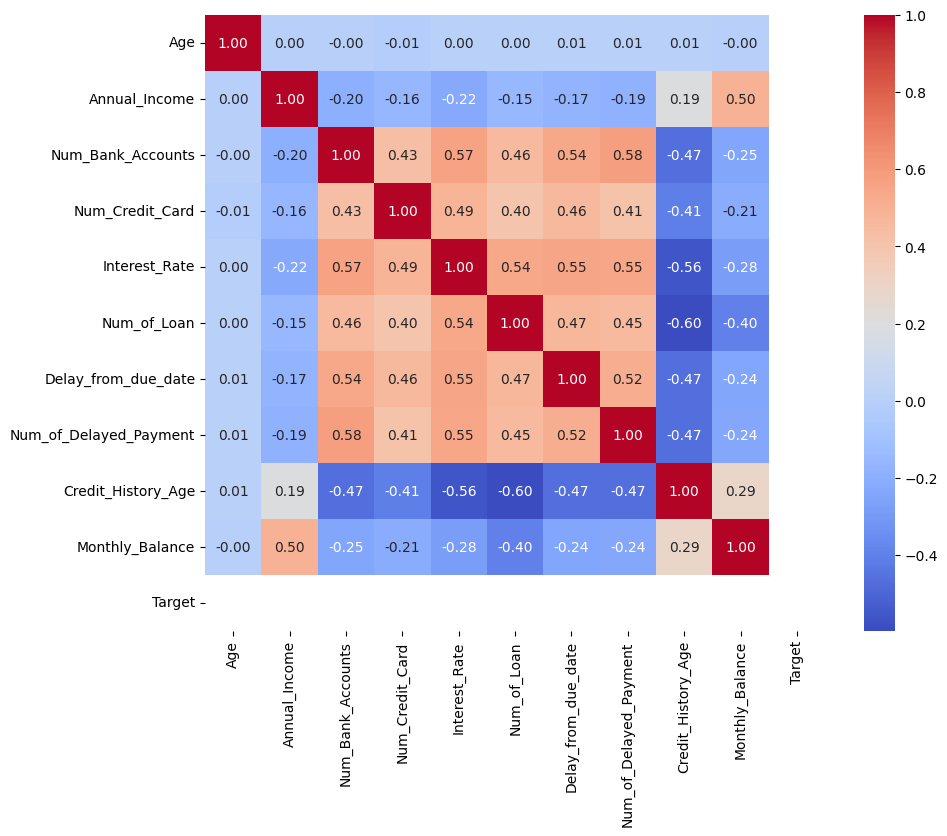

In [648]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

Now working with categorical data (ID,Customer_ID,Month, Name, SSN, Occupation, Type_of_Loan, Credit_Mix, Payment_of_Min_Amount, Payment_Behaviour)

Cleaning Data

In [649]:
df = df.drop(['SSN','Name','ID'], axis = 1)
df.columns

Index(['Customer_ID', 'Month', 'Age', 'Occupation', 'Annual_Income',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount',
       'Payment_Behaviour', 'Monthly_Balance', 'Target'],
      dtype='object')

Cleaning Occupation column

Cleaning Credit mix column

In [650]:
# Calculate the mode for the 'Credit_Mix' column
mode_value = df['Credit_Mix'].mode().iloc[0]

# Replace underscores with the mode value
df['Credit_Mix'].replace('_', mode_value, inplace=True)

# Drop rows containing NaN values
df.dropna(subset=['Credit_Mix'], inplace=True)

row = df.iloc[0]
print(row)

Customer_ID                                                       CUS_0xd40
Month                                                             September
Age                                                                      23
Occupation                                                        Scientist
Annual_Income                                                      19114.12
Num_Bank_Accounts                                                         3
Num_Credit_Card                                                           4
Interest_Rate                                                             3
Num_of_Loan                                                             4.0
Type_of_Loan              Auto Loan, Credit-Builder Loan, Personal Loan,...
Delay_from_due_date                                                     3.0
Num_of_Delayed_Payment                                                  7.0
Credit_Mix                                                             Good
Credit_Histo

In [651]:
df['Name'] = df.groupby('Customer_ID')['Name'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)).reset_index(drop=True)

KeyError: 'Column not found: Name'

In [ ]:
df['Ocuppation'] = df.groupby('Customer_ID')['Occupation'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)).reset_index(drop=True)

In [ ]:
df['Credit_Mix'] = df.groupby('Customer_ID')['Credit_Mix'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)).reset_index(drop=True)

In [ ]:
df['Payment_of_Min_Ammount'] = df.groupby('Customer_ID')['Payment_of_Min_Ammount'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)).reset_index(drop=True)

KeyError: 'Column not found: Payment_of_Min_Ammount'

In [ ]:
df['Payment_Behaviour'] = df.groupby('Customer_ID')['Payment_Behaviour'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)).reset_index(drop=True)

---

#### Código Viejo

In the ‘Occupation’ column, some rows contain symbols instead of an occupation name. These symbols are placeholders indicating that the occupation is not specified. However, to maintain consistency and clarity in our data, it’s better to represent these unspecified values with 'Unknown'.

In [ ]:
df.loc[df['Occupation'].str.isalpha() == False, 'Occupation'] = 'Unknown'
# Replace non-letter entries with None


In [ ]:
#We remove irrelevant and sensitive data that we mentioned before.
#df = df.drop(['ID','Customer_ID','Name','SSN','Month','Occupation','Monthly_Inhand_Salary','Interest_Rate'],axis=1)
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
28379,0x16295,CUS_0x1000,December,Alistair Barrf,18,913-74-1218,Lawyer,8489.19,6,5,...,3.0,"Credit-Builder Loan, and Home Equity Loan",5.0,25.0,Bad,11.083333,Yes,High_spent_Small_value_payments,227.820,-1
28378,0x16294,CUS_0x1000,November,NaN,18,913-74-1218,Lawyer,8489.19,6,5,...,3.0,"Credit-Builder Loan, and Home Equity Loan",40.0,25.0,Bad,11.000000,Yes,Low_spent_Medium_value_payments,164.409,-1
28377,0x16293,CUS_0x1000,October,Alistair Barrf,18,913-74-1218,Lawyer,8489.19,6,5,...,3.0,"Credit-Builder Loan, and Home Equity Loan",40.0,25.0,Bad,10.916667,Yes,Low_spent_Small_value_payments,256.350,-1
28376,0x16292,CUS_0x1000,September,Alistair Barrf,18,913-74-1218,Lawyer,8489.19,6,5,...,7.0,"Credit-Builder Loan, and Home Equity Loan",36.0,25.0,Bad,10.833333,Yes,Low_spent_Large_value_payments,500.575,-1
6883,0x66ad,CUS_0x1009,December,Arunah,26,063-67-6938,Mechanic,28849.66,6,5,...,5.0,"Not Specified, Home Equity Loan, Credit-Builde...",14.0,18.0,_,31.333333,Yes,High_spent_Medium_value_payments,199.567,-1


In [ ]:
# Modifying rows where data is unknown
# Define your condition for 'Payment_Behaviour' in the original df
specified_values = ['low_spent_small_value_payments', 'low_spent_medium_value_payments', 'low_spent_large_value_payments', 'high_spent_small_value_payments', 'high_spent_medium_value_payments', 'high_spent_large_value_payments']

# Use the `.apply()` method to update the 'Payment_Behaviour' column (case-insensitive)
df['Payment_Behaviour'] = df['Payment_Behaviour'].apply(lambda x: x.lower() if x.lower() in specified_values else 'Unknown')

Data Imputation before train test split (can maybe cause data leakage)

In [ ]:
# Define your imputers
""" imputer_income = SimpleImputer(strategy='median')
imputer_payment = SimpleImputer(strategy='median')
imputer_balance = SimpleImputer(strategy='median')

# Fit and transform 'Annual_Income' in the entire dataset
df['Annual_Income'] = imputer_income.fit_transform(df[['Annual_Income']])

# Fit and transform 'Num_of_Delayed_Payment' in the entire dataset
df['Num_of_Delayed_Payment'] = imputer_payment.fit_transform(df[['Num_of_Delayed_Payment']])

# Fit and transform 'Monthly_Balance' in the entire dataset
df['Monthly_Balance'] = imputer_balance.fit_transform(df[['Monthly_Balance
"""

# Define the columns you want to impute
columns_to_impute = ['Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Credit_History_Age']

# Create a SimpleImputer for mode imputation
imputer = SimpleImputer(strategy='most_frequent')

# Define a custom function for imputation
def impute_mode(group):
    return imputer.fit_transform(group.values.reshape(-1, 1)).flatten()

# Group the data by 'Customer_ID' and impute the missing values with the mode of each customer
df[columns_to_impute] = df.groupby('Customer_ID')[columns_to_impute].transform(impute_mode)


# Check if any NaN values remain
print(df.isnull().sum())

# print(df_copy.dtypes)


c:\Users\icono\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\icono\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\icono\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\icono\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: [0]. At least one non-mis

ID                           0
Customer_ID                  0
Month                        0
Name                      2949
Age                          0
SSN                          0
Occupation                   0
Annual_Income                0
Num_Bank_Accounts            0
Num_Credit_Card              0
Interest_Rate                0
Num_of_Loan                  0
Type_of_Loan              3250
Delay_from_due_date          0
Num_of_Delayed_Payment       0
Credit_Mix                   0
Credit_History_Age           0
Payment_of_Min_Amount        0
Payment_Behaviour            0
Monthly_Balance              0
Target                       0
dtype: int64


In [ ]:

# Define the categories that matter
categories = ['Bad', 'Standard', 'Good']

# Replace all other categories with 'Unknown' in the 'Credit_Mix' column
df['Credit_Mix'] = np.where(df['Credit_Mix'].isin(categories), df['Credit_Mix'], 'Unknown')



#Remove irrelevant columns
df = df.drop(['ID','Customer_ID','Name','SSN','Month','Occupation','Monthly_Inhand_Salary','Interest_Rate'],axis=1)
# Select only numeric columns from df
numeric_df = df.select_dtypes(include=[np.number])

# Create a correlation matrix
correlation_matrix = numeric_df.corr()

# Print or visualize the correlation matrix
print(correlation_matrix)

# Create a heatmap to visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
df

KeyError: "['Monthly_Inhand_Salary'] not found in axis"

In [ ]:
#Doing train test split before encoding
from sklearn.model_selection import train_test_split
loan_types = ['Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan',  'Mortgage Loan','Payday Loan','Student Loan','Debt Consolidation Loan','Not Specified','Payday Loan']

# Define your target variable
y = df['Target']

# Define your feature set
X = df.drop('Target', axis=1)

# Split your data
#We split our data before imputations to prevent data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
# Create a new column for each loan type that counts the number of occurrences
for loan in loan_types:
    X_train[loan] = X_train['Type_of_Loan'].apply(lambda x: x.count(loan) if isinstance(x, str) else 0)
    X_test[loan] = X_test['Type_of_Loan'].apply(lambda x: x.count(loan) if isinstance(x, str) else 0)

# If a row doesn't fall into any of these categories, mark it as 'Not Specified'
X_train['Not Specified'] = X_train[loan_types].apply(lambda x: 0 if any(x) else 1, axis=1)
X_test['Not Specified'] = X_test[loan_types].apply(lambda x: 0 if any(x) else 1, axis=1)

# Now you can drop the original 'Type_of_Loan' column
X_train = X_train.drop('Type_of_Loan', axis=1)
X_test = X_test.drop('Type_of_Loan', axis=1)
X_train

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,...,Monthly_Balance,Auto Loan,Credit-Builder Loan,Personal Loan,Home Equity Loan,Mortgage Loan,Payday Loan,Student Loan,Debt Consolidation Loan,Not Specified
30720,21,171572.160,2,3,4,3,8.0,Good,29.250000,No,...,1.187418e+09,0,1,0,0,1,1,0,1,0
19541,500,18608.170,7,8,6,24,18.0,Bad,9.916667,Yes,...,3.354730e+09,1,1,1,0,1,1,0,1,0
36045,52,31151.460,0,3,3,7,4.0,Unknown,16.333333,NM,...,4.140521e+09,0,0,1,0,0,2,0,0,0
28862,37,60537.180,7,4,2,19,19.0,Standard,31.500000,Yes,...,5.399853e+09,0,1,0,0,0,1,0,0,0
35949,41,58051.530,10,7,8,28,18.0,Bad,16.333333,Yes,...,2.936302e+09,2,0,0,0,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7501,41,8446.315,9,6,6,24,13.0,Standard,9.916667,Yes,...,2.864266e+09,1,1,1,0,2,0,0,0,0
13628,51,35205.450,3,7,3,8,11.0,Good,31.500000,No,...,4.108771e+09,0,0,2,1,0,0,0,0,0
45874,31,121151.400,3,4,2,11,7.0,Good,29.250000,No,...,7.099556e+09,0,2,0,0,0,0,0,0,0
1026,16,7495.305,6,5,4,22,16.0,Unknown,6.750000,Yes,...,2.777064e+09,0,1,0,0,0,1,1,1,0


Fixing column names so they properly follow a format.

In [ ]:
# Define English stopwords
stop_words = set(stopwords.words('english'))

# Define a function to clean column names
def clean_column_name(col_name):
    # Split the column name into words
    words = col_name.split()
    # Remove stopwords and capitalize the first letter of non-stopwords
    cleaned_name = ' '.join(word.title() if word not in stop_words else word for word in words)
    # Replace spaces with underscores
    cleaned_name = re.sub(r'\s+', '_', cleaned_name)
    return cleaned_name

# Apply the function to each column name in the training
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]
X_train

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_Of_Loan,Delay_From_Due_Date,Num_Of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_Of_Min_Amount,...,Monthly_Balance,Auto_Loan,Credit-Builder_Loan,Personal_Loan,Home_Equity_Loan,Mortgage_Loan,Payday_Loan,Student_Loan,Debt_Consolidation_Loan,Not_Specified
30720,21,171572.160,2,3,4,3,8.0,Good,29.250000,No,...,1.187418e+09,0,1,0,0,1,1,0,1,0
19541,500,18608.170,7,8,6,24,18.0,Bad,9.916667,Yes,...,3.354730e+09,1,1,1,0,1,1,0,1,0
36045,52,31151.460,0,3,3,7,4.0,Unknown,16.333333,NM,...,4.140521e+09,0,0,1,0,0,2,0,0,0
28862,37,60537.180,7,4,2,19,19.0,Standard,31.500000,Yes,...,5.399853e+09,0,1,0,0,0,1,0,0,0
35949,41,58051.530,10,7,8,28,18.0,Bad,16.333333,Yes,...,2.936302e+09,2,0,0,0,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7501,41,8446.315,9,6,6,24,13.0,Standard,9.916667,Yes,...,2.864266e+09,1,1,1,0,2,0,0,0,0
13628,51,35205.450,3,7,3,8,11.0,Good,31.500000,No,...,4.108771e+09,0,0,2,1,0,0,0,0,0
45874,31,121151.400,3,4,2,11,7.0,Good,29.250000,No,...,7.099556e+09,0,2,0,0,0,0,0,0,0
1026,16,7495.305,6,5,4,22,16.0,Unknown,6.750000,Yes,...,2.777064e+09,0,1,0,0,0,1,1,1,0


Age                        0
Annual_Income              0
Num_Bank_Accounts          0
Num_Credit_Card            0
Num_Of_Loan                0
Delay_From_Due_Date        0
Num_Of_Delayed_Payment     0
Credit_Mix                 0
Credit_History_Age         0
Payment_Of_Min_Amount      0
Payment_Behaviour          0
Monthly_Balance            0
Auto_Loan                  0
Credit-Builder_Loan        0
Personal_Loan              0
Home_Equity_Loan           0
Mortgage_Loan              0
Payday_Loan                0
Student_Loan               0
Debt_Consolidation_Loan    0
Not_Specified              0
dtype: int64


<Axes: >

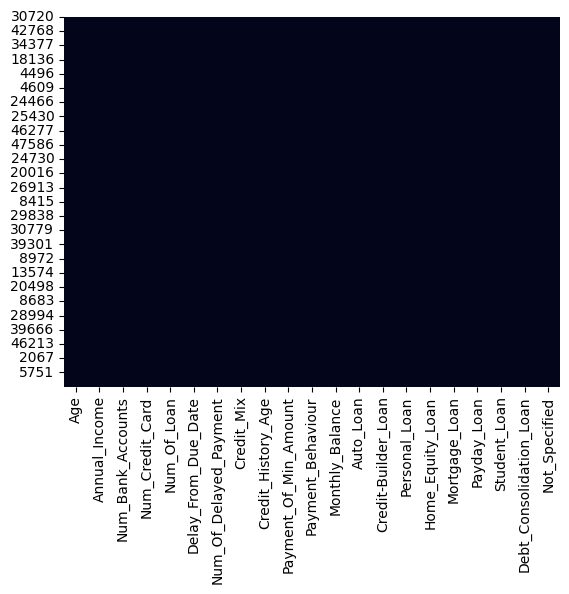

In [ ]:
print(X_train.isnull().sum())
sns.heatmap(X_train.isnull(), cbar=False)

---

Ordinal Encoding for Credit_Mix.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Create the encoder and specify the category ordering
encoder = OrdinalEncoder(categories=[['Bad','Unknown','Standard', 'Good']])

# Fit and transform the 'Credit_Mix' column in the training set
credit_mix_encoded_train = encoder.fit_transform(X_train[['Credit_Mix']])

# Transform the 'Credit_Mix' column in the test set
credit_mix_encoded_test = encoder.transform(X_test[['Credit_Mix']])

# Replace the original 'Credit_Mix' column with the encoded version in both sets
X_train['Credit_Mix'] = credit_mix_encoded_train
X_test['Credit_Mix'] = credit_mix_encoded_test
X_train

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_Of_Loan,Delay_From_Due_Date,Num_Of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_Of_Min_Amount,...,Monthly_Balance,Auto_Loan,Credit-Builder_Loan,Personal_Loan,Home_Equity_Loan,Mortgage_Loan,Payday_Loan,Student_Loan,Debt_Consolidation_Loan,Not_Specified
30720,21,171572.160,2,3,4,3,8.0,3.0,29.250000,No,...,1.187418e+09,0,1,0,0,1,1,0,1,0
19541,500,18608.170,7,8,6,24,18.0,0.0,9.916667,Yes,...,3.354730e+09,1,1,1,0,1,1,0,1,0
36045,52,31151.460,0,3,3,7,4.0,1.0,16.333333,NM,...,4.140521e+09,0,0,1,0,0,2,0,0,0
28862,37,60537.180,7,4,2,19,19.0,2.0,31.500000,Yes,...,5.399853e+09,0,1,0,0,0,1,0,0,0
35949,41,58051.530,10,7,8,28,18.0,0.0,16.333333,Yes,...,2.936302e+09,2,0,0,0,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7501,41,8446.315,9,6,6,24,13.0,2.0,9.916667,Yes,...,2.864266e+09,1,1,1,0,2,0,0,0,0
13628,51,35205.450,3,7,3,8,11.0,3.0,31.500000,No,...,4.108771e+09,0,0,2,1,0,0,0,0,0
45874,31,121151.400,3,4,2,11,7.0,3.0,29.250000,No,...,7.099556e+09,0,2,0,0,0,0,0,0,0
1026,16,7495.305,6,5,4,22,16.0,1.0,6.750000,Yes,...,2.777064e+09,0,1,0,0,0,1,1,1,0


In [ ]:
# Create a new encoder for 'Payment_Of_Min_Amount'
payment_encoder = OrdinalEncoder(categories=[['No', 'NM', 'Yes']])

# Fit and transform the 'Payment_Of_Min_Amount' column in the training set
payment_encoded_train = payment_encoder.fit_transform(X_train[['Payment_Of_Min_Amount']])

# Transform the 'Payment_Of_Min_Amount' column in the test set
payment_encoded_test = payment_encoder.transform(X_test[['Payment_Of_Min_Amount']])

# Replace the original 'Payment_Of_Min_Amount' column with the encoded version in both sets
X_train['Payment_Of_Min_Amount'] = payment_encoded_train
X_test['Payment_Of_Min_Amount'] = payment_encoded_test

Converting to integers some values.

In [ ]:
# Convert 'Credit_Mix' and 'Num_Of_Delayed_Payment' to integer
X_train['Credit_Mix'] = X_train['Credit_Mix'].astype(int)
X_train['Num_Of_Delayed_Payment'] = X_train['Num_Of_Delayed_Payment'].astype(int)

# Convert 'Credit_Mix' and 'Num_Of_Delayed_Payment' to integer
X_test['Credit_Mix'] = X_test['Credit_Mix'].astype(int)
X_test['Num_Of_Delayed_Payment'] = X_test['Num_Of_Delayed_Payment'].astype(int)

X_train['Payment_Of_Min_Amount'] = X_train['Payment_Of_Min_Amount'].astype(int)
X_test['Payment_Of_Min_Amount'] = X_test['Payment_Of_Min_Amount'].astype(int)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33267 entries, 30720 to 19071
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      33267 non-null  int64  
 1   Annual_Income            33267 non-null  float64
 2   Num_Bank_Accounts        33267 non-null  int64  
 3   Num_Credit_Card          33267 non-null  int64  
 4   Num_Of_Loan              33267 non-null  int64  
 5   Delay_From_Due_Date      33267 non-null  int64  
 6   Num_Of_Delayed_Payment   33267 non-null  int32  
 7   Credit_Mix               33267 non-null  int32  
 8   Credit_History_Age       33267 non-null  float64
 9   Payment_Of_Min_Amount    33267 non-null  int32  
 10  Payment_Behaviour        33267 non-null  object 
 11  Monthly_Balance          33267 non-null  float64
 12  Auto_Loan                33267 non-null  int64  
 13  Credit-Builder_Loan      33267 non-null  int64  
 14  Personal_Loan          

In [ ]:
X_train = pd.get_dummies(X_train, columns=['Payment_Behaviour'], prefix=['Payment_Behaviour'])
X_test = pd.get_dummies(X_test, columns=['Payment_Behaviour'], prefix=['Payment_Behaviour'])
X_train

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_Of_Loan,Delay_From_Due_Date,Num_Of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_Of_Min_Amount,...,Student_Loan,Debt_Consolidation_Loan,Not_Specified,Payment_Behaviour_Unknown,Payment_Behaviour_high_spent_large_value_payments,Payment_Behaviour_high_spent_medium_value_payments,Payment_Behaviour_high_spent_small_value_payments,Payment_Behaviour_low_spent_large_value_payments,Payment_Behaviour_low_spent_medium_value_payments,Payment_Behaviour_low_spent_small_value_payments
30720,21,171572.160,2,3,4,3,8,3,29.250000,0,...,0,1,0,False,True,False,False,False,False,False
19541,500,18608.170,7,8,6,24,18,0,9.916667,2,...,0,1,0,True,False,False,False,False,False,False
36045,52,31151.460,0,3,3,7,4,1,16.333333,1,...,0,0,0,False,False,True,False,False,False,False
28862,37,60537.180,7,4,2,19,19,2,31.500000,2,...,0,0,0,False,False,False,True,False,False,False
35949,41,58051.530,10,7,8,28,18,0,16.333333,2,...,2,0,0,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7501,41,8446.315,9,6,6,24,13,2,9.916667,2,...,0,0,0,False,False,False,False,False,False,True
13628,51,35205.450,3,7,3,8,11,3,31.500000,0,...,0,0,0,False,False,True,False,False,False,False
45874,31,121151.400,3,4,2,11,7,3,29.250000,0,...,0,0,0,False,False,False,False,True,False,False
1026,16,7495.305,6,5,4,22,16,1,6.750000,2,...,1,1,0,False,False,True,False,False,False,False


In [ ]:
# Get the boolean columns
bool_cols = [col for col in X_train.columns if X_train[col].dtype == bool]

# Convert boolean columns to integers
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

---

#### Outliers removal

Removing bank accounts outliers

Removing outliers from Num_Credit_Card

Removing outliers from Num_of_Loan

Removing outliers from Delay_From_Due_Date

Removing outliers from Num_Of_Delayed_Payment

Removing outliers from Monthly_Balance

---

Remember to check if we need scaling

---

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

1. Oversampling the Minority Class:

In [ ]:
# from imblearn.over_sampling import SMOTE

# # Create an instance of SMOTE
# smote = SMOTE(random_state=42)

# # Fit and resample the training data
# X_train, y_train = smote.fit_resample(X_train, y_train)

Logistic Regression

In [ ]:
# Instance the model and train it
#WE NEED TO ENCODE PAYMENT_BEHAVIOUR
#logreg_model = LogisticRegression()
#logreg_model.fit(X_train, y_train)

In [ ]:
# Make predictions of the data
y_pred = logreg_model.predict(X_train)

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [ ]:
# Obtain relevant metrics from the test and predictions results
accuracy = accuracy_score(y_train, y_pred)
#confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_train, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.9330783938814532
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     31720
           1       0.00      0.00      0.00      2275

    accuracy                           0.93     33995
   macro avg       0.47      0.50      0.48     33995
weighted avg       0.87      0.93      0.90     33995



c:\Users\icono\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\icono\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\icono\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred)

# Generate classification report
report = classification_report(y_train, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

# Perform cross-validation
scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")

Accuracy: 0.9999705839093984
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31720
           1       1.00      1.00      1.00      2275

    accuracy                           1.00     33995
   macro avg       1.00      1.00      1.00     33995
weighted avg       1.00      1.00      1.00     33995

Cross-validation scores: [0.99911752 0.99882336 0.99941168 0.99911752 0.99970584]
Average cross-validation score: 0.9992351816443594
